# Vector database comparison for AI Workloads: Elasticsearch vs. MongoDB Atlas Vector Search

While both MongoDB Atlas and Elasticsearch can store vector embeddings for AI applications, they serve fundamentally different purposes. This notebook explores multiple approaches to implementing vector search, compering their benefits and challenges:

1. **Elasticsearch for Vector Search:**

   Elasticsearch is primarely a search engine optimized for information retriaval and analitics. It efficiently handles vector embeddings to enable semantic search capabilities. In this notebook, we demonstrate how to implement vector search with Elasticsearch, highlighting its search optimizations capabilities

2. **MongoDB Atlas for Unified AI Workloads:**

   MongoDB Atlas is a fully-featured database with built-in vector search capabilities. As a true database, it offers ACID complience - ensuring Automicity, Consistency, Isolation and Durability - which is essential for production AI applicatios that require data reliability. We illustrate how to implement vector search using MongoDB Atlas, showcasting its ability to handle both vector search and traditional database operations within a unified system.

3. **Split Architecture vs. Unified Architecture:**
   - **Split Architecture:** In this approach, vector embeddings are stored in Elasticsearch to leverage its search capabilities, while metadata and other critical information are managed in MongoDB Atlas. This model allows you to utilize the strengths of both systems but produces challenges such as data synchronization and consistency between the two systems.
   - **Unified Architecture:** Alternatively MongoDB Atlas can be used to handle both vector search and data storage in a single system. Thi sunified approach simplifies the architecture by eliminating cross-database synchronization issues, ensuring robust ACID compliance and streamlined operations for AI workloads.

## Table of Contents

- **Part 1. Data Setup** - Installing libraries, setting up connections, preparing the dataset
- **Part 2. Elasticsearch Implementation** - Setting up and using Elasticsearch for vector search
- **Part 3. MongoDB Atlas Implementation** - Setting up and using MongoDB Atlas for vector search
- **Part 4. Split Architecture** - Implementing a hybrid approach (Elastic as vector datbase and MongoDB as operational) with both databases
- **Part 5. Unified Architecture** - Using MongoDB Atlas for both vector search and data storage
- **Part 6. Performance Guidance** - Overview of the benefits of a unified architecture

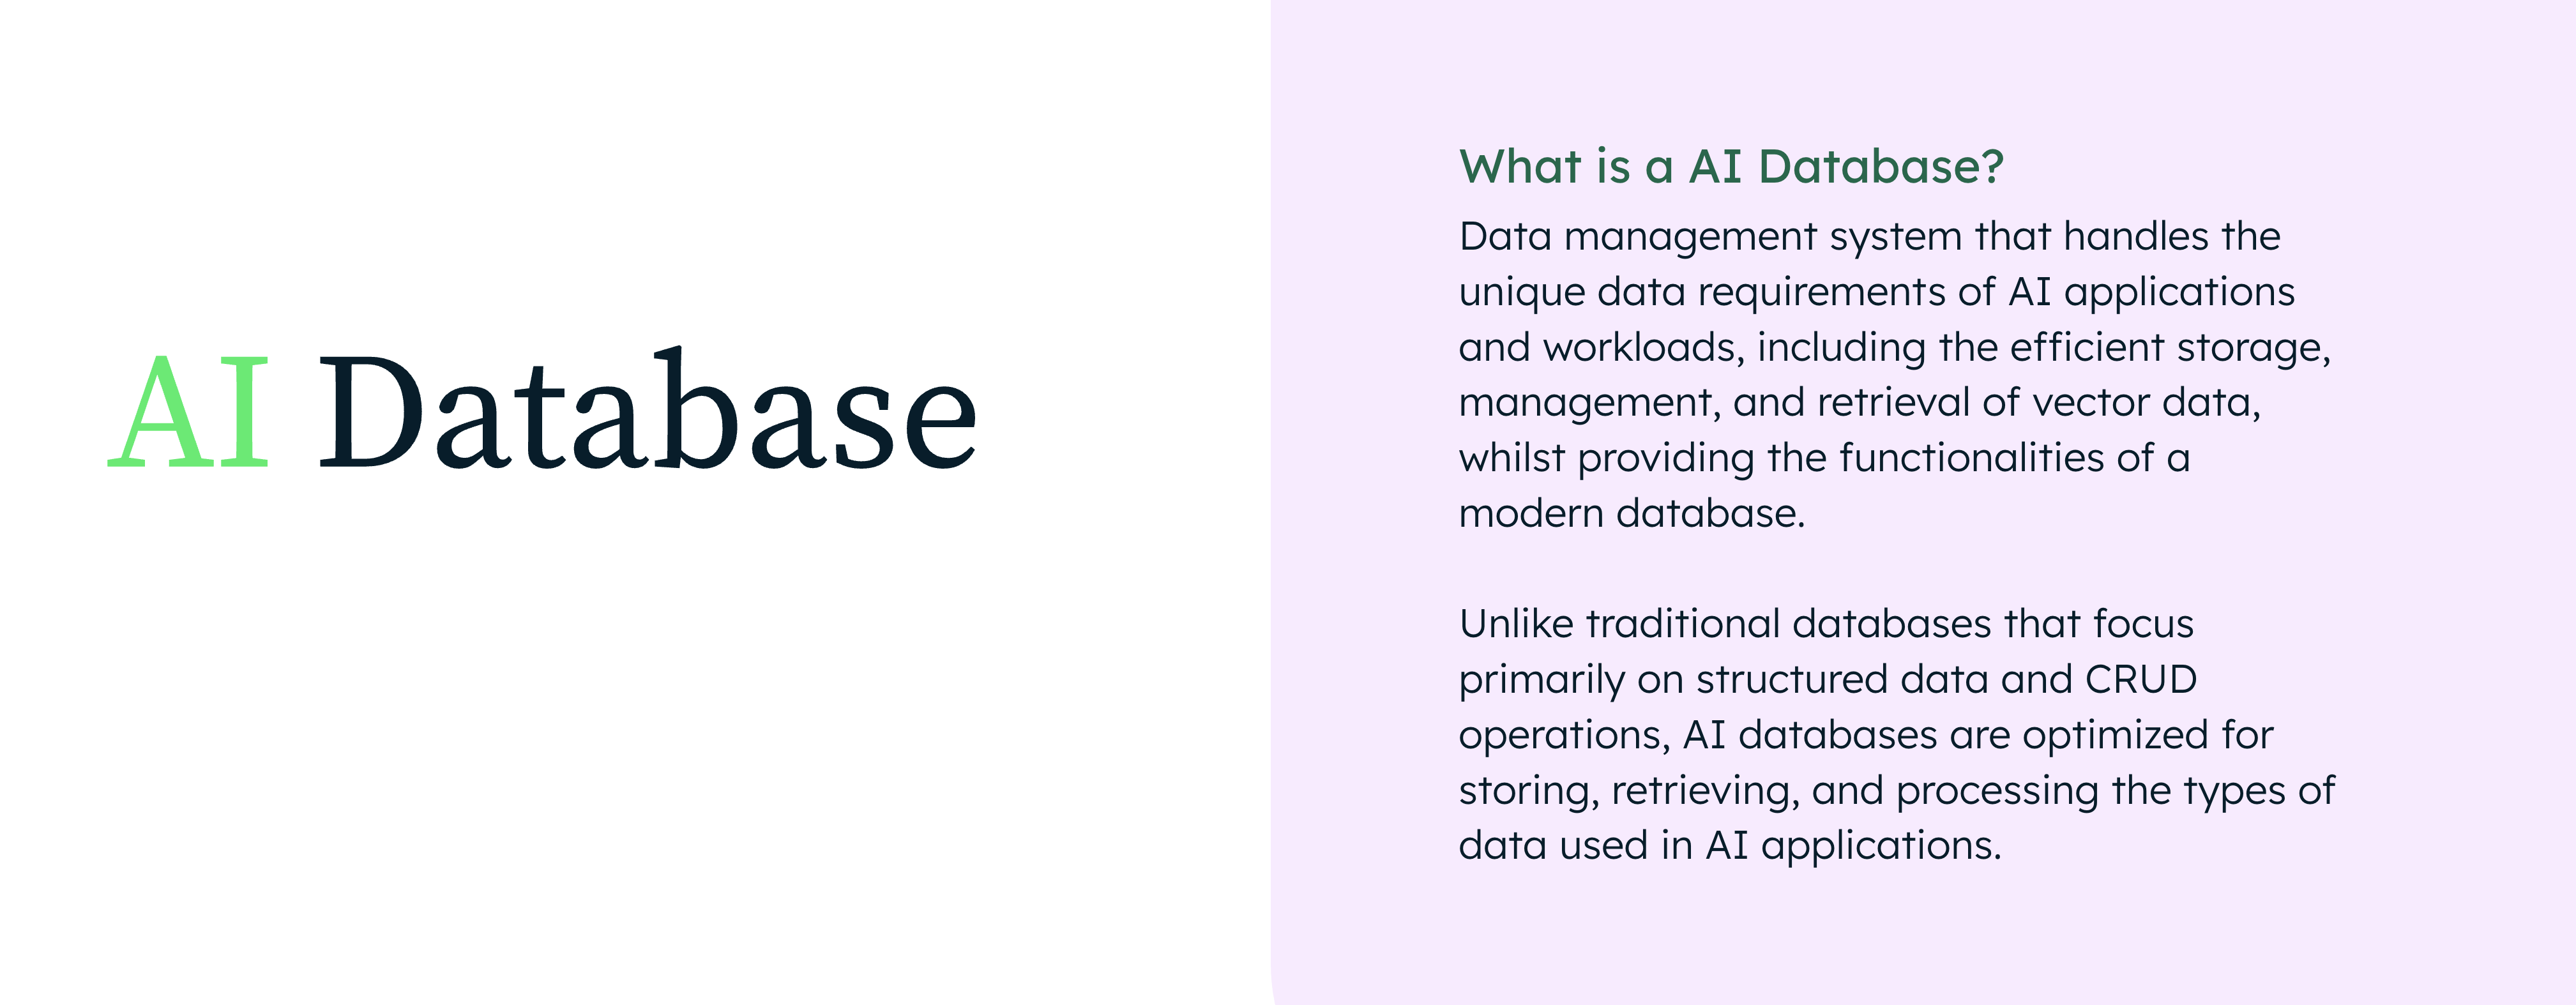

## Part 1: Data Setup

In [1]:
import getpass
import os

# Function to securely get and set environment variables
def set_env_securely(var_name, prompt):
    value = getpass.getpass(prompt)
    os.environ[var_name] = value

### Step 1: Install Libraries

All the libraries are installed using `pip` and facilitate the sourcing of data, embedding generation and data visualization.

- `datasets`: Hugging Face library for managing and preprocessing datasets across text, image and audio (https://huggingface.co/datasets)
- `voyageai`: A library for creating sentence embeddings for tasks like semantic search and clustering (https://voyageai.com/)
- `pandas`: A library for data manipulation and analysis with DataFrames and Series (https://pandas.pydata.org/)
- `matplotlib`: A library for creating static, interactive and animated data visualizations (https://matplotlib.org/)

In [3]:
%pip install --upgrade datasets voyageai pandas matplotlib

   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ----- ---------------------------------- 1.6/11.0 MB 8.3 MB/s eta 0:00:02
   ------------ --------------------------- 3.4/11.0 MB 8.4 MB/s eta 0:00:01
   ------------------- -------------------- 5.2/11.0 MB 8.4 MB/s eta 0:00:01
   ------------------------- -------------- 7.1/11.0 MB 8.4 MB/s eta 0:00:01
   -------------------------------- ------- 8.9/11.0 MB 8.4 MB/s eta 0:00:01
   ------------------------------------- -- 10.2/11.0 MB 8.2 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 7.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ------ --------------------------------- 1.3/8.1 MB 6.7 MB/s eta 0:00:02
   ------------ --------------------------- 2.6/8.1 MB 6.6 MB/s eta 0:00:01
   ------------------- -------------------- 3.9/8.1 MB 6.5 MB/s eta 0:00:01
   --------------------------- ------------ 5.5/8.1 MB 6.7 MB/s eta 0:00:01
   -------------

  You can safely remove it manually.
  You can safely remove it manually.

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart kernel to use updated packages

### Step 2: Data Loading

In [4]:
# Import necessary libraries
# data sets is a Hugging Face library for accessing and working with datasets
# pandas is used for data manipulation and analysis
import pandas as pd
from datasets import load_dataset

c:\Users\yulic\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
wikipedia_data_amount = 1000

In [6]:
# Load the wikipedia annotation data
wikipedia_data = load_dataset(
    "MongoDB/wikipedia-22-12-en-voyage-embed", streaming=True, split="train"
)

In [7]:
wikipedia_data_head = wikipedia_data.take(wikipedia_data_amount)
wikipedia_data_df = pd.DataFrame(wikipedia_data_head)

In [9]:
# Drop the _id, wiki_id, views, paragraph_id, section_id and langs columns
# These columns are not needed for the vector search
wikipedia_data_df = wikipedia_data_df.drop(
    columns=["_id", "id", "wiki_id", "views", "paragraph_id", "langs"]
)

# Convert the text embedding to a list of floats from a string
wikipedia_data_df["embedding"] = wikipedia_data_df["embedding"].apply(lambda x: eval(x))

wikipedia_data_df.head()

,title,text,url,embedding
0,YouTube,YouTube is a global online video sharing and s...,https://en.wikipedia.org/wiki?curid=3524766,"[-0.0270681083202362, 0.0237626451998949, -0.0..."
1,YouTube,"In October 2006, YouTube was bought by Google ...",https://en.wikipedia.org/wiki?curid=3524766,"[-0.0442084409296512, 0.0446286313235759, -0.0..."
2,YouTube,"Since its purchase by Google, YouTube has expa...",https://en.wikipedia.org/wiki?curid=3524766,"[-0.0241227727383375, 0.0164146348834037, -0.0..."
3,YouTube,YouTube has had an unprecedented social impact...,https://en.wikipedia.org/wiki?curid=3524766,"[-0.0028252257034182, 0.0495448783040046, 0.00..."
4,YouTube,"YouTube was founded by Steve Chen, Chad Hurley...",https://en.wikipedia.org/wiki?curid=3524766,"[-0.0574200861155986, 0.0406263954937458, -0.0..."
